In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
date= most_recent_date.date
date

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_data = session.query(Measurement).order_by(Measurement.date.desc()).first()
most_recent_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28b88c2e518>,
 'tobs': 81.0,
 'id': 2724,
 'date': '2017-08-23',
 'prcp': 0.0,
 'station': 'USC00519397'}

In [11]:
# Calculate the date one year from the last date in data set.
# convert string to datetime object to avoid error
date_time_obj = dt.datetime.strptime(date, '%Y-%m-%d').date()
# Find timedelta between latest date and 12 months ago
date_12months_ago = date_time_obj- dt.timedelta(days=365)
#convert the datetime object back to string
date_12months_ago = date_12months_ago.strftime('%Y-%m-%d')
date_12months_ago

'2016-08-23'

In [12]:
# Perform a query to retrieve the data and precipitation scores
last_12months_data = session.query(Measurement.date, Measurement.prcp).\
                     filter(Measurement.date >= date_12months_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

last_12_months_df = pd.DataFrame(last_12months_data , columns = ['Date', 'Precipitation'])
last_12_months_df.set_index('Date' , inplace=True)

# Sort the dataframe by date
last_12_months_df = last_12_months_df.sort_values(by= 'Date')
last_12_months_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [13]:
# Drop Null values
last_12_months_df = last_12_months_df.dropna(how ='any')

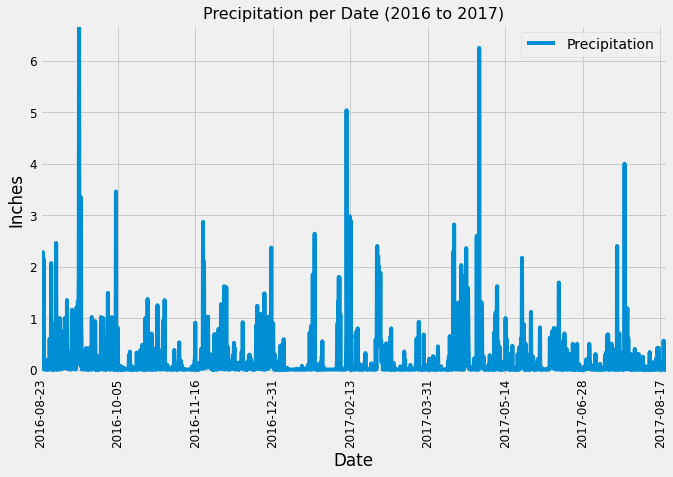

<Figure size 432x288 with 0 Axes>

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12_months_df.plot( kind ="line" , y = 'Precipitation', figsize = (10,6) , rot =90 , fontsize = 12)

plt.title("Precipitation per Date (2016 to 2017)" , fontsize = 16)
plt.legend(["Precipitation"] , loc= 'best')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xlim(0, len(last_12_months_df))
plt.ylim(min(last_12_months_df['Precipitation'])-0.1, max(last_12_months_df['Precipitation']))

#Save histogram
plt.savefig("Images/precipitaion_plot.png")
plt.show()
plt.tight_layout()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_months_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Station.id).all()
pd.DataFrame({"Num_Sation" : [len(num_stations)]})

,Num_Sation
0,9


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count = func.count(Measurement.station)
most_active_station = session.query(Measurement.station , station_count).\
                      group_by(Measurement.station).order_by(station_count.desc()).first()

most_active_station[0]

'USC00519281'

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == most_active_station[0]).first()

pd.DataFrame({'Min_temp': [active_station_temp[0]],
              'Max_temp' :[active_station_temp[1]],
              'Avg_temp': [round(active_station_temp[2], 3)]
             })

,Min_temp,Max_temp,Avg_temp
0,54.0,85.0,71.664


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_last_12mon_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active_station[0]).\
                                                          filter(Measurement.date >= date_12months_ago).all()
station_last_12mon_temp[:10]

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0)]

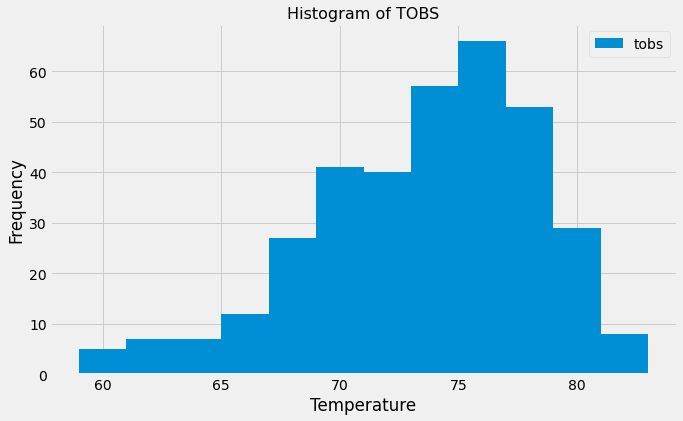

<Figure size 432x288 with 0 Axes>

In [27]:
#Generate a histogram of tobs for last 1 year
x = pd.DataFrame(station_last_12mon_temp , columns = ['tobs'])
plt.figure(figsize=(10,6))
plt.hist(x , bins = 12 )

plt.title("Histogram of TOBS" , fontsize = 16)
plt.legend(["tobs"] , loc= 'best')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.savefig(".\Images\histogram.png")
plt.show()
plt.tight_layout()

# Close session

In [21]:
# Close Session
session.close()